In [273]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [274]:
data = "processed_dataset.csv"

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [275]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [276]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

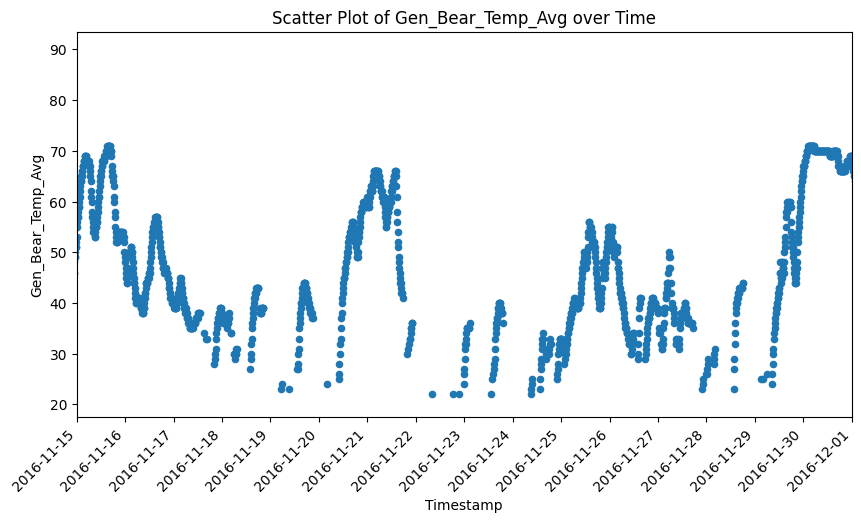

In [277]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


## Custom features

In [278]:
# creating data columns for the xgboost regressor

# Air density

# acceleration last x seconds

# Can we implement average speed for the last 30 minutes

# C_p?

# tip speed ratio

# Angle of blades

# Wind direction

# wind speed modified for distributed wind speed on diameter of blade

Air density 

In [279]:


# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df["T"] = merged_df["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df["p"] = merged_df["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df["e_s"] = 6.112 * np.exp((17.67 * merged_df["Amb_Temp_Avg"]) / (merged_df["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df["RH_frac"] = merged_df["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df["p_v"] = merged_df["RH_frac"] * merged_df["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df["p_d"] = merged_df["p"] - merged_df["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df["airdensity"] = (merged_df["p_d"] / (R_d * merged_df["T"])) + (merged_df["p_v"] / (R_v * merged_df["T"]))

# Optionally, drop intermediate columns if not needed
merged_df.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df[["airdensity"]].head())


   airdensity
0    1.195193
1    1.198984
2    1.198896
3    1.193996
4    1.203438


## Xgboost model:

In [280]:
"""import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

# Step 2: Specify the feature columns and the target variable
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]  # Features
target_column = 'Gen_Bear_Temp_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model
model = XGBRegressor()  # Use XGBClassifier() if it's a classification task

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)

# Step 8: Evaluate the model on merged_df (Optional)
# This evaluation is only for the training dataset, not merged_df17
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    # If the target variable has two unique values, treat it as a classification problem
    train_predictions = model.predict(X_train)
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # If it's a regression problem, calculate the mean squared error
    train_predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, train_predictions)
    print(f'Mean Squared Error on Training Data: {mse:.2f}')

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions"""


'import pandas as pd\nfrom xgboost import XGBRegressor\nfrom sklearn.metrics import mean_squared_error, accuracy_score\n\n# Step 2: Specify the feature columns and the target variable\nfeature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]  # Features\ntarget_column = \'Gen_Bear_Temp_Avg\'  # Target variable\n\n# Step 3: Prepare the training data from merged_df\nX_train = merged_df[feature_columns]  # Feature set for training\ny_train = merged_df[target_column]   # Target variable for training\n\n# Step 4: Prepare the prediction data from merged_df17\nX_test = merged_df17[feature_columns]  # Feature set for predictions\n\n# Step 5: Initialize the XGBoost model\nmodel = XGBRegressor()  # Use XGBClassifier() if it\'s a classification task\n\n# Step 6: Train the model\nmodel.fit(X_train, y_train)\n\n# Step 7: Make predictions on the merged_df17 dataset\npredictions = model.predict(X_test)\n\n# Step 8: Evaluate the model on merged_df (Opt

With hyperparameters from Olivers thesis:

In [281]:
# Step 2: Specify the feature columns and the target variable
feature_columns = ["Amb_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Avg_Humidity","Avg_Pressure"]  # Features
target_column = 'Grd_Prod_Pwr_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model with optimal hyperparameters
model = XGBRegressor()

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)

# Step 8: Evaluate the model on merged_df (Optional)
train_predictions = model.predict(X_train)

# Check if the target variable is binary (classification)
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # Regression Metrics
    mse = mean_squared_error(y_train, train_predictions)
    mae = mean_absolute_error(y_train, train_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train, train_predictions)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100
    
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


Mean Squared Error (MSE): 1684.77
Mean Absolute Error (MAE): 27.19
Root Mean Squared Error (RMSE): 41.05
R² Score: 1.00
Mean Absolute Percentage Error (MAPE): 28.21%


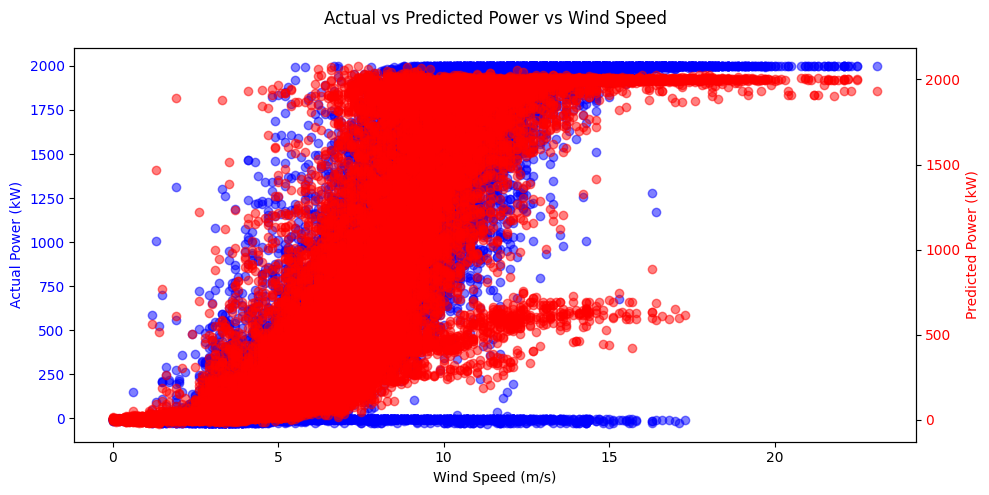

In [282]:
import matplotlib.pyplot as plt

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = merged_df17["Avg_Windspeed1"]  # Wind speed (X-axis)
y_actual = merged_df17["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = merged_df17["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="blue")
ax1.scatter(x, y_actual, color="blue", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="red")
ax2.scatter(x, y_predicted, color="red", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="red")

# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed")
fig.tight_layout()
plt.show()


In [283]:
print(merged_df17.columns)


Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
       ...
       'Anemometer2_Freq', 'Anemometer2_Offset', 'Anemometer2_CorrGain',
       'Anemometer2_CorrOffset', 'DistanceAirPress',
       'AirRessureSensorZeroOffset', 'Anemometer1_Avg_Freq',
       'Anemometer2_Avg_Freq', 'Pressure_Avg_Freq', 'xgboost_pred_2017'],
      dtype='object', length=124)


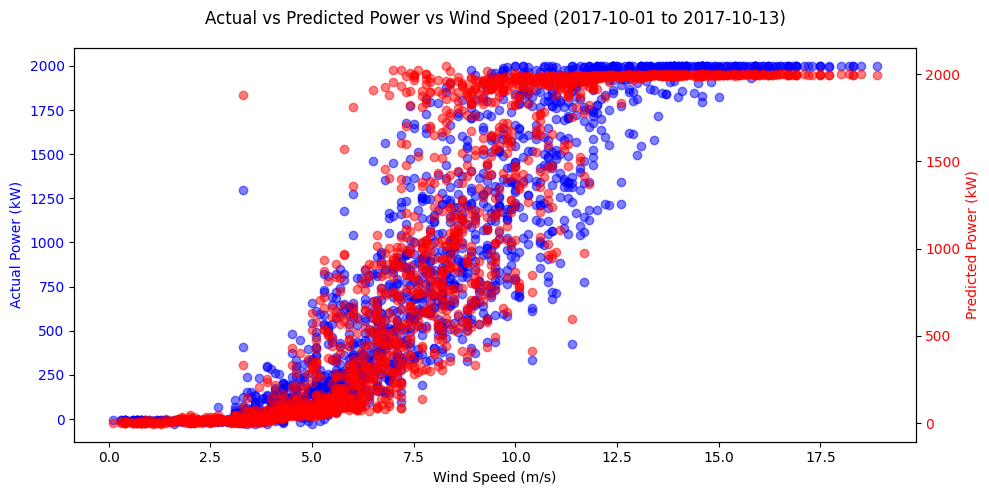

In [284]:
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Filter data for the date range 2017-10-01 to 2017-10-13
filtered_df = merged_df17[(merged_df17["Timestamp"] >= "2017-10-01") & 
                          (merged_df17["Timestamp"] <= "2017-10-13")]

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = filtered_df["Avg_Windspeed1"]  # Wind speed (X-axis)
y_actual = filtered_df["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = filtered_df["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="blue")
ax1.scatter(x, y_actual, color="blue", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="red")
ax2.scatter(x, y_predicted, color="red", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="red")

# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed (2017-10-01 to 2017-10-13)")
fig.tight_layout()
plt.show()


In [360]:
# error models

# total error = model error + sensor error + actual error + operational error

# Percentage model
percentage_error = (mape*0.01)


# mean error
mean_error = y_predicted-y_actual

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error = np.median(mean_error)

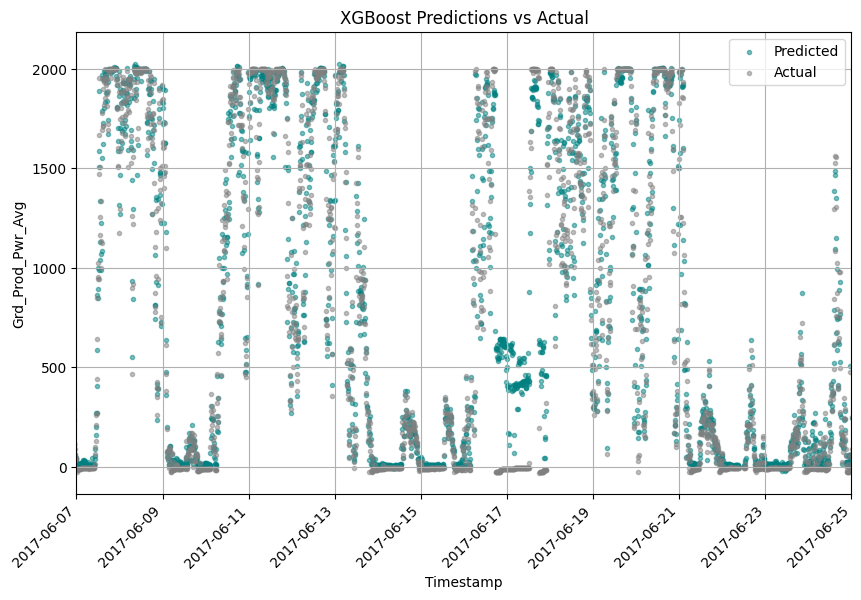

In [361]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


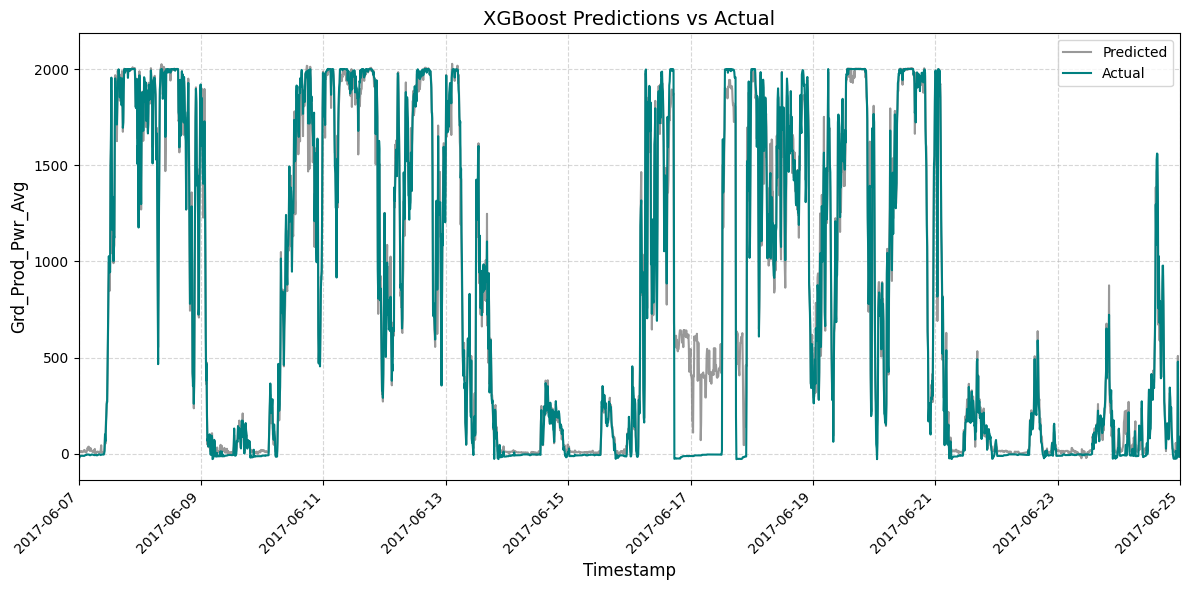

In [362]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


Replication of maneesh work to see if data is faulty after maintenance in

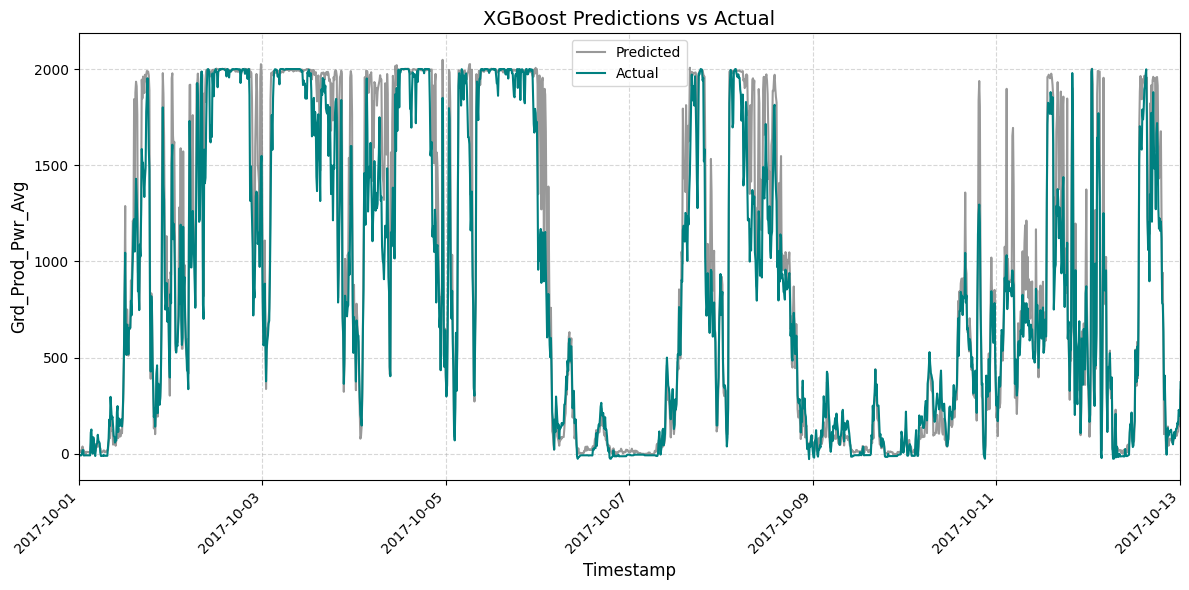

In [363]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


(np.float64(17324.0), np.float64(17525.0))

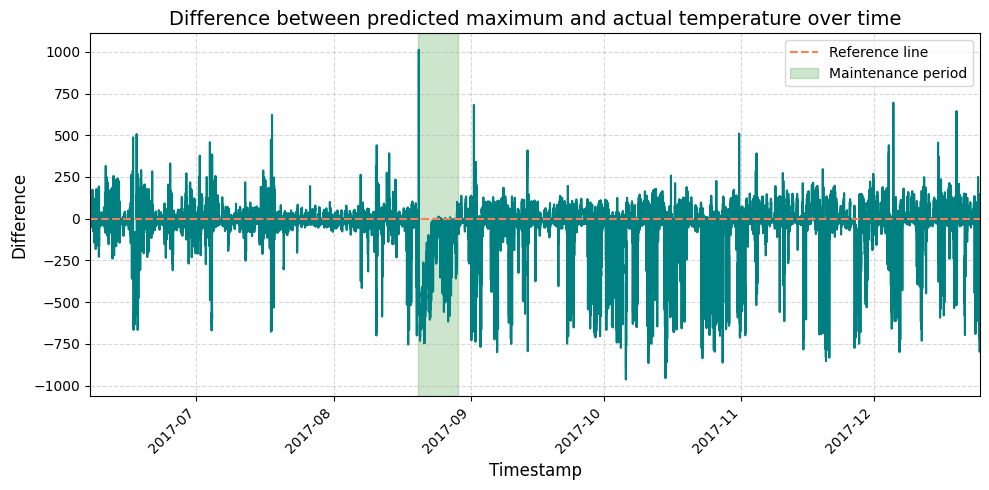

In [364]:
merged_df_filtered17_sorted["xgb_actual_diff"] =  merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]

plt.plot(merged_df_filtered17_sorted["Timestamp"],merged_df_filtered17_sorted["xgb_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")
# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")
# Configure plot
plt.title("Difference between predicted maximum and actual temperature over time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

Test of wide interval without uncertainty

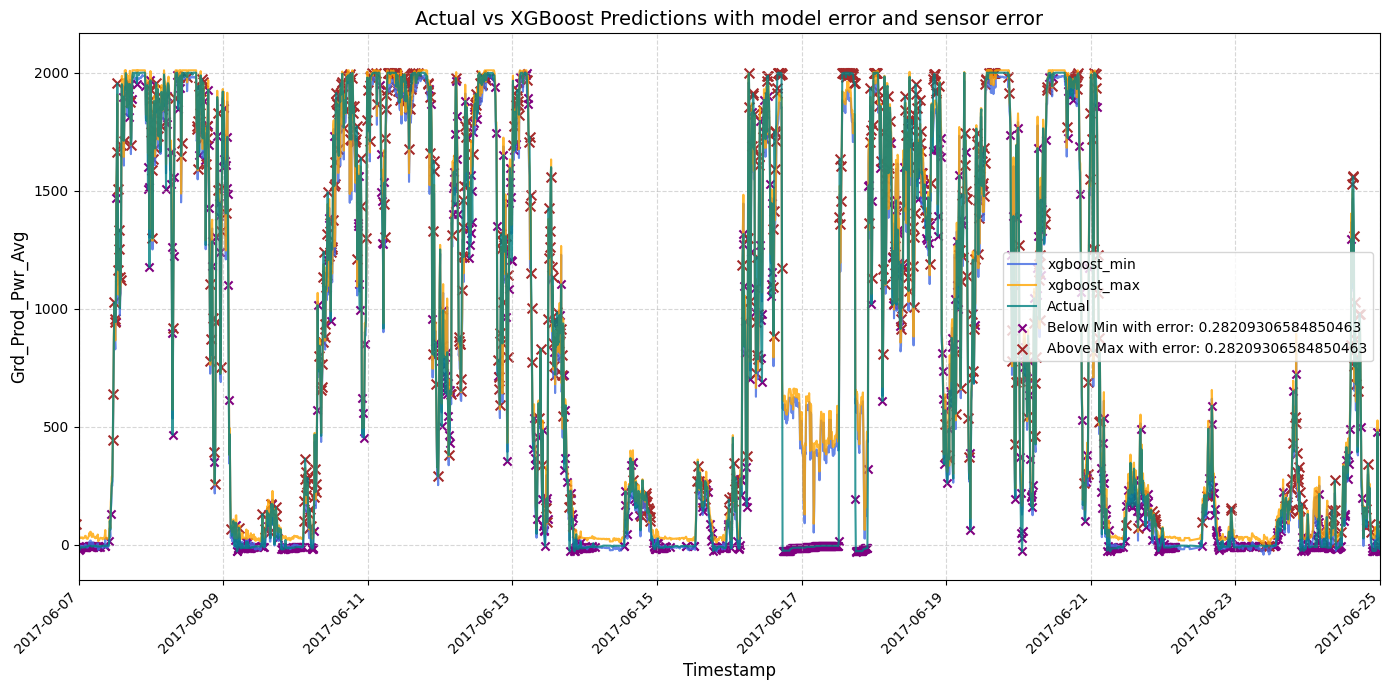

In [365]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - modelling_error
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] +modelling_error

# Here we cap the maximum to be 2050
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_max"].clip(upper=2010)

# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"]).astype(int)

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below xgboost_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Below Min with error: {percentage_error}'
)

# Scatter points where actual is above xgboost_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max with error: {percentage_error}'
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))
plt.title("Actual vs XGBoost Predictions with model error and sensor error", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


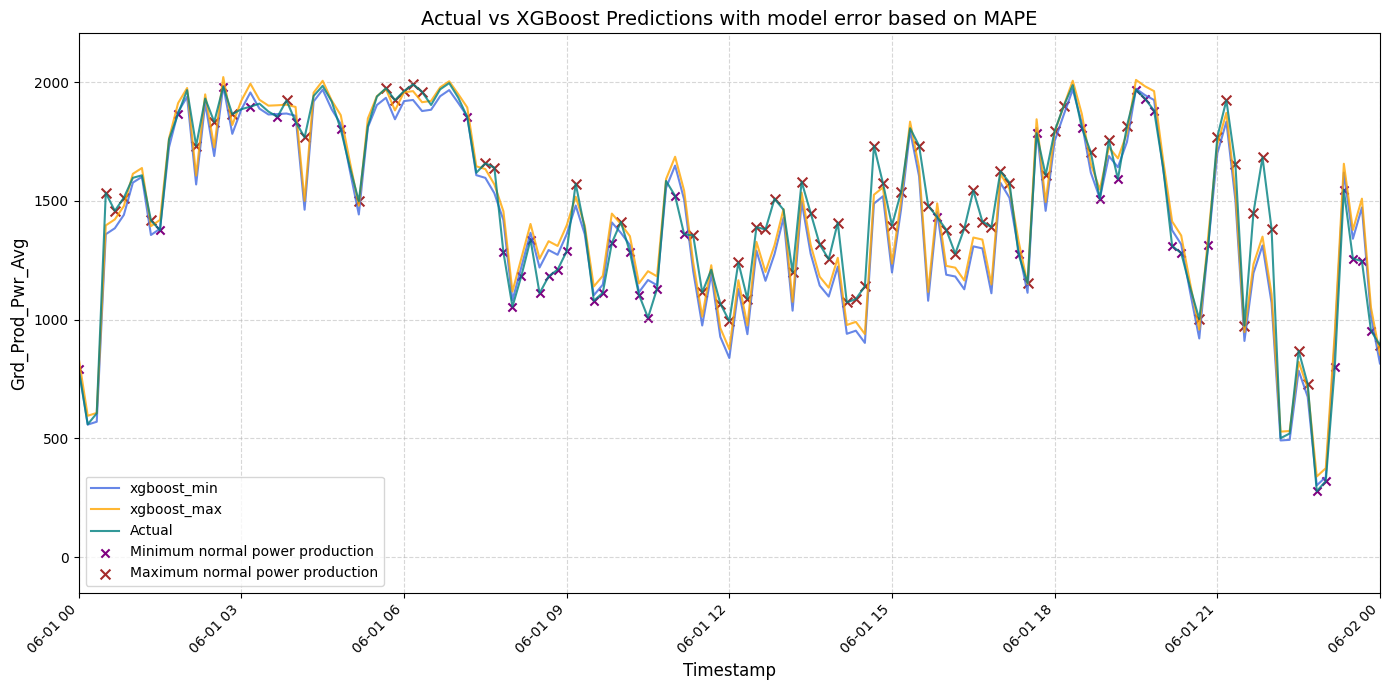

In [366]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] -modelling_error
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] +modelling_error


# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"])
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"])

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], target_column],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], target_column],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)


# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-01'), pd.to_datetime('2017-06-02'))
plt.title("Actual vs XGBoost Predictions with model error based on MAPE", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Smoothened plot

In [367]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

# Apply rolling average smoothing
rolling_window = 5  # Adjust window size as needed
merged_df_filtered17_sorted["xgboost_pred_2017_smoothed"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"].rolling(window=rolling_window).mean()
)
merged_df_filtered17_sorted["actual_smoothed"] = (
    merged_df_filtered17_sorted[target_column].rolling(window=rolling_window).mean()
)

# Plot
plt.figure(figsize=(12, 6))

# Line plot for smoothed predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017_smoothed"],  # Smoothed predictions
    color="teal",
    alpha=0.8,
    label="Predicted (Smoothed)",
    linestyle="-",
    linewidth=1.5,
)

# Line plot for smoothed actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["actual_smoothed"],  # Smoothed actual values
    color="grey",
    alpha=0.8,
    label="Actual (Smoothed)",
    linestyle="-",
    linewidth=1.5,
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime("2017-06-07"), pd.to_datetime("2017-06-25"))

# Title and labels
plt.title("XGBoost Predictions vs Actual (Smoothed)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])\n\n# Sort merged_df17 by "Timestamp" for better visualization\nmerged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")\n\n# Apply rolling average smoothing\nrolling_window = 5  # Adjust window size as needed\nmerged_df_filtered17_sorted["xgboost_pred_2017_smoothed"] = (\n    merged_df_filtered17_sorted["xgboost_pred_2017"].rolling(window=rolling_window).mean()\n)\nmerged_df_filtered17_sorted["actual_smoothed"] = (\n    merged_df_filtered17_sorted[target_column].rolling(window=rolling_window).mean()\n)\n\n# Plot\nplt.figure(figsize=(12, 6))\n\n# Line plot for smoothed predicted values\nplt.plot(\n    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps\n    merged_df_filtered17_sorted["xgboost_pred_2017_smoothed"],  # Smoothed predictions\n    color="teal",\n    alpha=0.8,\n    label="Predict

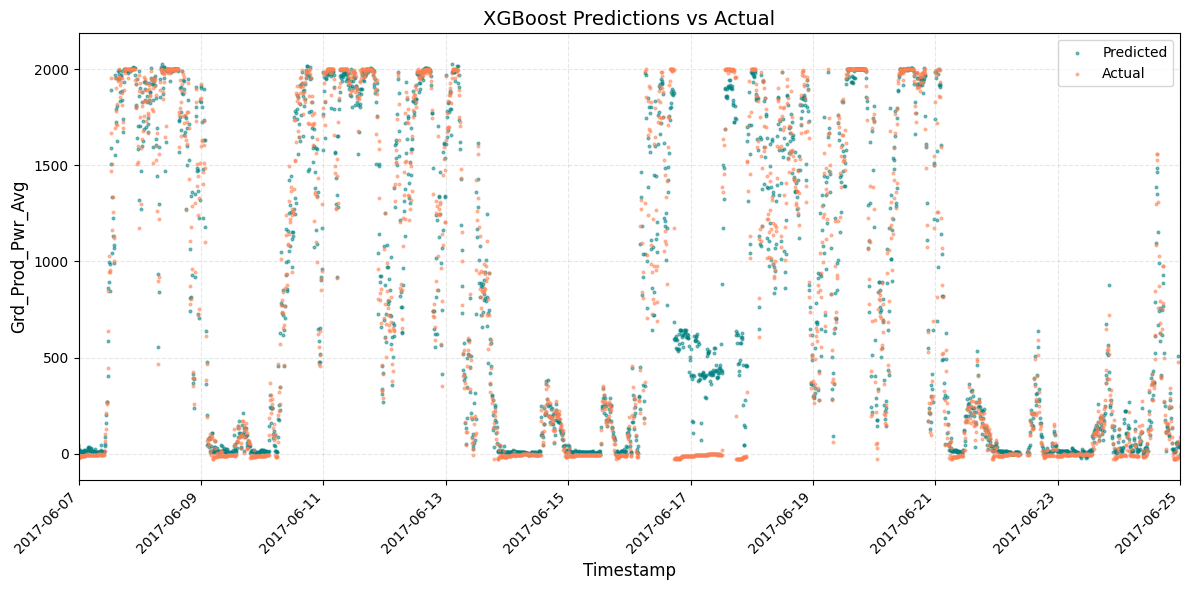

In [368]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


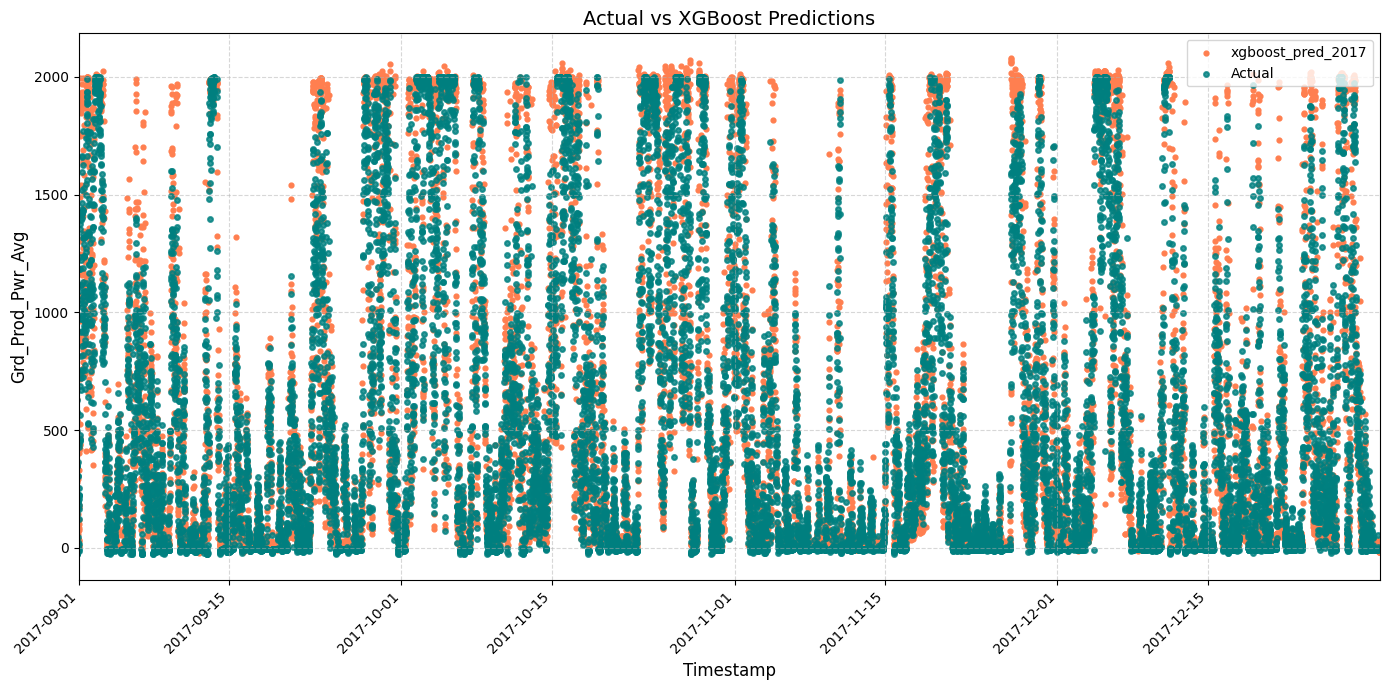

In [369]:
# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Start plotting
plt.figure(figsize=(14, 7))

# Scatter plot for xgboost predictions
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_pred_2017"],
    color='coral', marker='o', s=12, label='xgboost_pred_2017'
)

# Line plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, s=12,label='Actual', linestyle='-', linewidth=1.5
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-09-01'), pd.to_datetime('2017-12-31'))
plt.title("Actual vs XGBoost Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

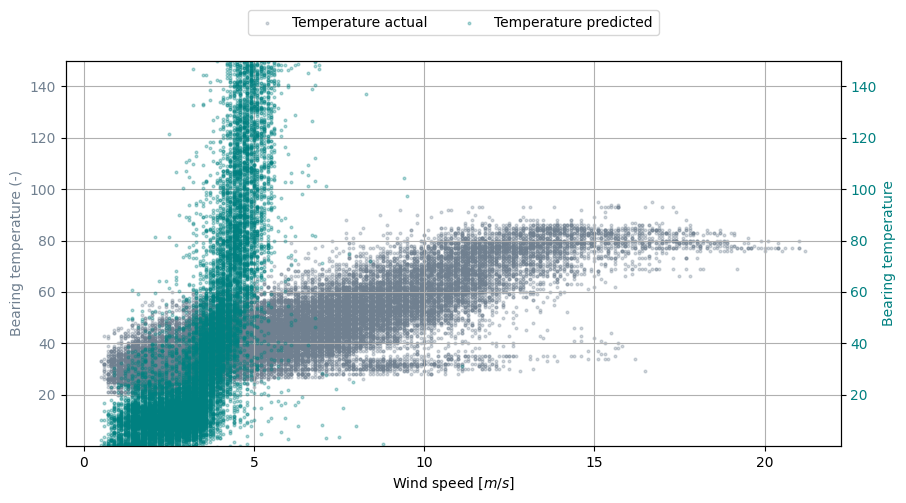

In [370]:
# Adjusted color scheme with burgundy and muted green
fig, ax1 = plt.subplots()  # Create a figure and axis

# Plotting the actual Cp values on the primary y-axis with burgundy
ax1.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], color='slategrey', label='Temperature actual', alpha=0.3, marker='.', s=15)
ax1.set_xlabel('Wind speed [$m/s$]')  # x-axis label
ax1.set_ylabel('Bearing temperature (-)', color='slategrey')  # Primary y-axis label color
ax1.tick_params(axis='y', labelcolor='slategrey')  # Primary y-axis label tick color
ax1.grid()
ax1.set_ylim(0.1, 150)  # Set y-limits for Cp values

# Create a secondary y-axis with a muted green color
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["xgboost_pred_2017"], color='teal', label='Temperature predicted', alpha=0.3, marker='.', s=15)  # Muted olive green color
ax2.set_ylabel('Bearing temperature', color='teal')  # Secondary y-axis label color
ax2.tick_params(axis='y', labelcolor='teal')  # Secondary y-axis label tick color
ax2.set_ylim(0.1, 150)

# Optional: Add legends for both y-axes with subtle colors
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=ax1.transAxes, ncol=2)

# Show the plot
plt.show()

# Intervals:

In [371]:
# check units of the independent variables to make sure that interval is correctly chosen:
["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]
# Get a statistical summary for the other columns

windspeed_summary = merged_df_filtered17_sorted["Avg_Windspeed1"].describe()
nac_temp_summary = merged_df_filtered17_sorted["Nac_Temp_Avg"].describe()
humidity_summary = merged_df_filtered17_sorted["Avg_Humidity"].describe()
print(f"Avg Windspeed Summary:\n{windspeed_summary}")
print(f"Nac Temp Avg Summary:\n{nac_temp_summary}")
print(f"Avg Humidity Summary:\n{humidity_summary}")


Avg Windspeed Summary:
count    34581.000000
mean         6.257465
std          3.527416
min          0.000000
25%          3.600000
50%          5.600000
75%          8.400000
max         23.100000
Name: Avg_Windspeed1, dtype: float64
Nac Temp Avg Summary:
count    34582.000000
mean        31.666994
std          5.829491
min         17.000000
25%         28.000000
50%         32.000000
75%         36.000000
max         50.000000
Name: Nac_Temp_Avg, dtype: float64
Avg Humidity Summary:
count    34582.000000
mean        63.366694
std         17.430912
min         11.000000
25%         51.000000
50%         65.000000
75%         77.000000
max         99.000000
Name: Avg_Humidity, dtype: float64


In [372]:
# Define intervals for each new feature as [-1, 1]
Amb_Temp_interval = [-2, 2]         # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-1, 1]          # RPM (for Gen_RPM_Avg)
Windspeed1_interval = [-1, 1]       # m/s (for Avg_Windspeed1)
Humidity_interval = [-0.5, 0.5]         # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]         # hPa? (for Avg_Pressure)


In [373]:


# Calculate maximum values by adding the max of each interval to the average values
merged_df_filtered17_sorted["max_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + max(Amb_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Avg_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + max(Windspeed1_interval)
merged_df_filtered17_sorted["max_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(Humidity_interval)
merged_df_filtered17_sorted["max_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + max(Pressure_interval)

# Calculate minimum values by adding the min of each interval to the average values
merged_df_filtered17_sorted["min_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + min(Amb_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Avg_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + min(Windspeed1_interval)
merged_df_filtered17_sorted["min_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + min(Humidity_interval)
merged_df_filtered17_sorted["min_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + min(Pressure_interval)


In [374]:
# Define the intervals for each feature
Amb_Temp_interval = [-2, 2]    # Celsius
Gen_RPM_interval = [-1, 1]     # RPM
Windspeed1_interval = [-1, 1]  # m/s
Humidity_interval = [-0.5, 0.5]    # percentage %
Pressure_interval = [-1, 1]    # hPa (adjust as necessary)

# Create 'min' and 'max' feature columns
merged_df_filtered17_sorted["min_Amb_Temp"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + min(Amb_Temp_interval)
merged_df_filtered17_sorted["max_Amb_Temp"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + max(Amb_Temp_interval)

merged_df_filtered17_sorted["min_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)

merged_df_filtered17_sorted["min_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + min(Windspeed1_interval)
merged_df_filtered17_sorted["max_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + max(Windspeed1_interval)

merged_df_filtered17_sorted["min_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + min(Humidity_interval)
merged_df_filtered17_sorted["max_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(Humidity_interval)

merged_df_filtered17_sorted["min_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + min(Pressure_interval)
merged_df_filtered17_sorted["max_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + max(Pressure_interval)


In [375]:
print(model.get_booster().feature_names)

['Amb_Temp_Avg', 'Gen_RPM_Avg', 'Avg_Windspeed1', 'Avg_Humidity', 'Avg_Pressure']


In [376]:
import pandas as pd
import itertools

# Define intervals for each feature
Amb_Temp_interval = [-2, 2]        # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-1, 1]         # RPM (for Gen_RPM_Avg)
Windspeed1_interval = [-1, 1]      # m/s (for Avg_Windspeed1)
Humidity_interval = [-0.5, 0.5]        # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]        # hPa? (for Avg_Pressure)

# Generate all 32 combinations of interval adjustments
combinations = list(itertools.product(
    Amb_Temp_interval,
    Gen_RPM_interval,
    Windspeed1_interval,
    Humidity_interval,
    Pressure_interval
))

# Iterate through the 32 combinations
for idx, combo in enumerate(combinations):
    Amb_Temp_val, Gen_RPM_val, Windspeed_val, Humidity_val, Pressure_val = combo

    # Apply the combination adjustments to the time series
    X_test = pd.DataFrame({
        'Amb_Temp_Avg': merged_df_filtered17_sorted["Amb_Temp_Avg"] + Amb_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val,
        'Avg_Pressure': merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
    })

    # Predict with the model for the entire time series
    predictions = model.predict(X_test)

    # Store predictions in the DataFrame
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    print(f"Combination {idx+1}: Prediction completed for the entire time series.")

# Optionally, save or visualize the modified DataFrame
# merged_df_filtered17_sorted.to_csv('predictions_with_combinations.csv', index=False)


Combination 1: Prediction completed for the entire time series.
Combination 2: Prediction completed for the entire time series.
Combination 3: Prediction completed for the entire time series.
Combination 4: Prediction completed for the entire time series.
Combination 5: Prediction completed for the entire time series.
Combination 6: Prediction completed for the entire time series.
Combination 7: Prediction completed for the entire time series.
Combination 8: Prediction completed for the entire time series.
Combination 9: Prediction completed for the entire time series.
Combination 10: Prediction completed for the entire time series.
Combination 11: Prediction completed for the entire time series.
Combination 12: Prediction completed for the entire time series.
Combination 13: Prediction completed for the entire time series.
Combination 14: Prediction completed for the entire time series.
Combination 15: Prediction completed for the entire time series.
Combination 16: Prediction complet

In [377]:
# Define the 'min' and 'max' columns
min_columns = ["min_Amb_Temp", "min_Gen_RPM", "min_Windspeed1", "min_Humidity", "min_Pressure"]
max_columns = ["max_Amb_Temp", "max_Gen_RPM", "max_Windspeed1", "max_Humidity", "max_Pressure"]

# Generate all 32 combinations of 'min' and 'max' features
combinations = []
for i in range(32):
    combination = []
    for j in range(5):
        if (i >> j) & 1:
            combination.append(max_columns[j])  # Use max for this feature
        else:
            combination.append(min_columns[j])  # Use min for this feature
    combinations.append(combination)

# Ensure the correct feature order for the model
feature_columns = ["Amb_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Avg_Humidity", "Avg_Pressure"]

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Reorder columns to ensure proper order (optional, but ensures consistency)
    combination_features = combination_features[feature_columns]
    
    # Generate predictions for the current combination
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame as a new column
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions

# Check results
print(merged_df_filtered17_sorted.head())


      Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
52211        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
12009        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
81550        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
32490        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
5835         T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
52211       1336.5         47.6               36.0                   58   
12009       1307.9         34.7               36.0                   58   
81550       1325.9         41.4               36.0                   58   
32490       1322.4         44.7               36.0                   58   
5835        1292.4         31.1               36.0                   58   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
52211                   58                   58  ...   
1200

In [378]:
# Ensure correct feature order for predictions
feature_columns = ["Amb_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Avg_Humidity", "Avg_Pressure"]


# Verify the range of min and max columns
for col in min_columns + max_columns:
    print(f"{col} - Min: {merged_df_filtered17_sorted[col].min()}, Max: {merged_df_filtered17_sorted[col].max()}")

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Ensure alignment of feature columns with the model's expectations
    combination_features = combination_features[feature_columns]
    
    # Debug: Check the range of features before prediction
    print(f"Combination {idx} - Feature ranges:")
    print(combination_features.describe())
    
    # Generate predictions
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions



min_Amb_Temp - Min: 5, Max: 37
min_Gen_RPM - Min: -1.0, Max: 1682.8
min_Windspeed1 - Min: -1.0, Max: 22.1
min_Humidity - Min: 10.5, Max: 98.5
min_Pressure - Min: 990.0, Max: 1029.0
max_Amb_Temp - Min: 9, Max: 41
max_Gen_RPM - Min: 1.0, Max: 1684.8
max_Windspeed1 - Min: 1.0, Max: 24.1
max_Humidity - Min: 11.5, Max: 99.5
max_Pressure - Min: 992.0, Max: 1031.0
Combination 1 - Feature ranges:
       Amb_Temp_Avg   Gen_RPM_Avg  Avg_Windspeed1  Avg_Humidity  Avg_Pressure
count  34582.000000  34582.000000    34581.000000  34582.000000  34581.000000
mean      20.133596   1066.409869        5.257465     62.866694   1009.006217
std        5.331173    611.287551        3.527416     17.430912      4.796108
min        5.000000     -1.000000       -1.000000     10.500000    990.000000
25%       17.000000    282.000000        2.600000     50.500000   1006.000000
50%       20.000000   1265.600000        4.600000     64.500000   1008.000000
75%       24.000000   1602.500000        7.400000     76.50000

In [379]:
"""import matplotlib.pyplot as plt

# Plot predictions for all 32 combinations with subplots
fig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations
axes = axes.flatten()  # Flatten the 2D grid for easy iteration

# Iterate through combinations
for idx, combo in enumerate(combinations):
    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo

    X_test = pd.DataFrame({
        'Gen_Phase1_Temp_Avg': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Nac_Temp_Avg': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model
    predictions = model.predict(X_test)
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    ax = axes[idx]
    ax.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
               color='slategrey', alpha=0.3, marker='.', s=15, label='Temperature actual')
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], predictions,
                color='teal', alpha=0.3, marker='.', s=15, label=f'Pred_comb_{idx+1}')

    ax.set_title(f'Combination {idx+1}')
    ax.set_xlabel('Wind Speed [$m/s$]')
    ax.set_ylabel('Bearing Temperature (-)', color='slategrey')
    ax.tick_params(axis='y', labelcolor='slategrey')
    ax2.set_ylabel('Predictions', color='teal')

# Show the overall plot
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\n\n# Plot predictions for all 32 combinations with subplots\nfig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations\naxes = axes.flatten()  # Flatten the 2D grid for easy iteration\n\n# Iterate through combinations\nfor idx, combo in enumerate(combinations):\n    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo\n\n    X_test = pd.DataFrame({\n        \'Gen_Phase1_Temp_Avg\': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,\n        \'Gen_RPM_Avg\': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,\n        \'Avg_Windspeed1\': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,\n        \'Nac_Temp_Avg\': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,\n        \'Avg_Humidity\': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val\n    })\n\n    # Predict with the model\n    predictions = model.predict(X_test)\n    merged_df_filtered1

In [380]:

print(merged_df_filtered17_sorted.iloc[0])


Turbine_ID                                         T07
Timestamp                    2017-01-01 00:00:00+00:00
Gen_RPM_Max                                     1513.4
Gen_RPM_Min                                     1255.3
Gen_RPM_Avg                                     1336.5
                                       ...            
combination_28_prediction                    361.37381
combination_29_prediction                   321.228241
combination_30_prediction                   345.867188
combination_31_prediction                   331.413788
combination_32_prediction                   356.052734
Name: 52211, Length: 208, dtype: object


In [381]:
# Display the first 5 rows of the DataFrame
print(merged_df_filtered17_sorted.head())


      Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
52211        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
12009        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
81550        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
32490        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
5835         T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
52211       1336.5         47.6               36.0                   58   
12009       1307.9         34.7               36.0                   58   
81550       1325.9         41.4               36.0                   58   
32490       1322.4         44.7               36.0                   58   
5835        1292.4         31.1               36.0                   58   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
52211                   58                   58  ...   
1200

In [382]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure relevant columns are numeric
merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], errors="coerce")
merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], errors="coerce")

# Plot predictions for all 32 combinations with subplots
fig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations
axes = axes.flatten()  # Flatten the 2D grid for easy iteration

# Iterate through combinations
for idx, combo in enumerate(combinations):
    # Prepare values from combinations
    humidity_val = 0 if 'min_Humidity' in combo else 1
    Gen_Phase1_Temp_val = 0 if 'min_Gen_Phase1_Temp' in combo else 1
    Gen_RPM_val = 0 if 'min_Gen_RPM' in combo else 1
    Windspeed_val = 0 if 'min_Windspeed1' in combo else 1
    Nac_Temp_val = 0 if 'min_Nac_Temp' in combo else 1

    # Create a test DataFrame
    X_test = pd.DataFrame({
        "Gen_Phase1_Temp_Avg": merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        "Gen_RPM_Avg": merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        "Avg_Windspeed1": merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        "Nac_Temp_Avg": merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        "Avg_Humidity": merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model
    predictions = model.predict(X_test)
    merged_df_filtered17_sorted[f"pred_comb_{idx+1}"] = predictions

    # Scatter plots
    ax = axes[idx]
    ax.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
               color="slategrey", alpha=0.3, marker=".", s=15, label="Temperature actual")
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], predictions,
                color="teal", alpha=0.3, marker=".", s=15, label=f"Pred_comb_{idx+1}")

    # Set titles and labels
    ax.set_title(f"Combination {idx+1}")
    ax.set_xlabel("Wind Speed [$m/s$]")
    ax.set_ylabel("Bearing Temperature (-)", color="slategrey")
    ax.tick_params(axis="y", labelcolor="slategrey")
    ax2.set_ylabel("Predictions", color="teal")

# Show the overall plot
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure relevant columns are numeric\nmerged_df_filtered17_sorted["Amb_WindSpeed_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], errors="coerce")\nmerged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], errors="coerce")\n\n# Plot predictions for all 32 combinations with subplots\nfig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations\naxes = axes.flatten()  # Flatten the 2D grid for easy iteration\n\n# Iterate through combinations\nfor idx, combo in enumerate(combinations):\n    # Prepare values from combinations\n    humidity_val = 0 if \'min_Humidity\' in combo else 1\n    Gen_Phase1_Temp_val = 0 if \'min_Gen_Phase1_Temp\' in combo else 1\n    Gen_RPM_val = 0 if \'min_Gen_RPM\' in combo else 1\n    Windspeed_val = 0 if \'min_Windspeed1\' in combo else 1\n    Nac_Temp_val = 0 if \'min_Nac_Temp\' in combo else 1\n\n    # 

In [383]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Identify prediction columns (e.g., columns starting with 'pred_comb_')
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure numeric types for prediction columns
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted['row_min'] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted['row_max'] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Scatter plot of min and max predictions
plt.figure(figsize=(10, 6))

# Scatter for min predictions
plt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
            merged_df_filtered17_sorted["row_min"], 
            color='blue', alpha=0.5, label='Row Min Predictions', s=15)

# Scatter for max predictions
plt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
            merged_df_filtered17_sorted["row_max"], 
            color='red', alpha=0.5, label='Row Max Predictions', s=15)

# Plot settings
plt.xlabel('Wind Speed [$m/s$]')
plt.ylabel('Predictions')
plt.title('Row-wise Min and Max Predictions Across Combinations')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


_IncompleteInputError: incomplete input (621542473.py, line 1)

## Only sensor error:

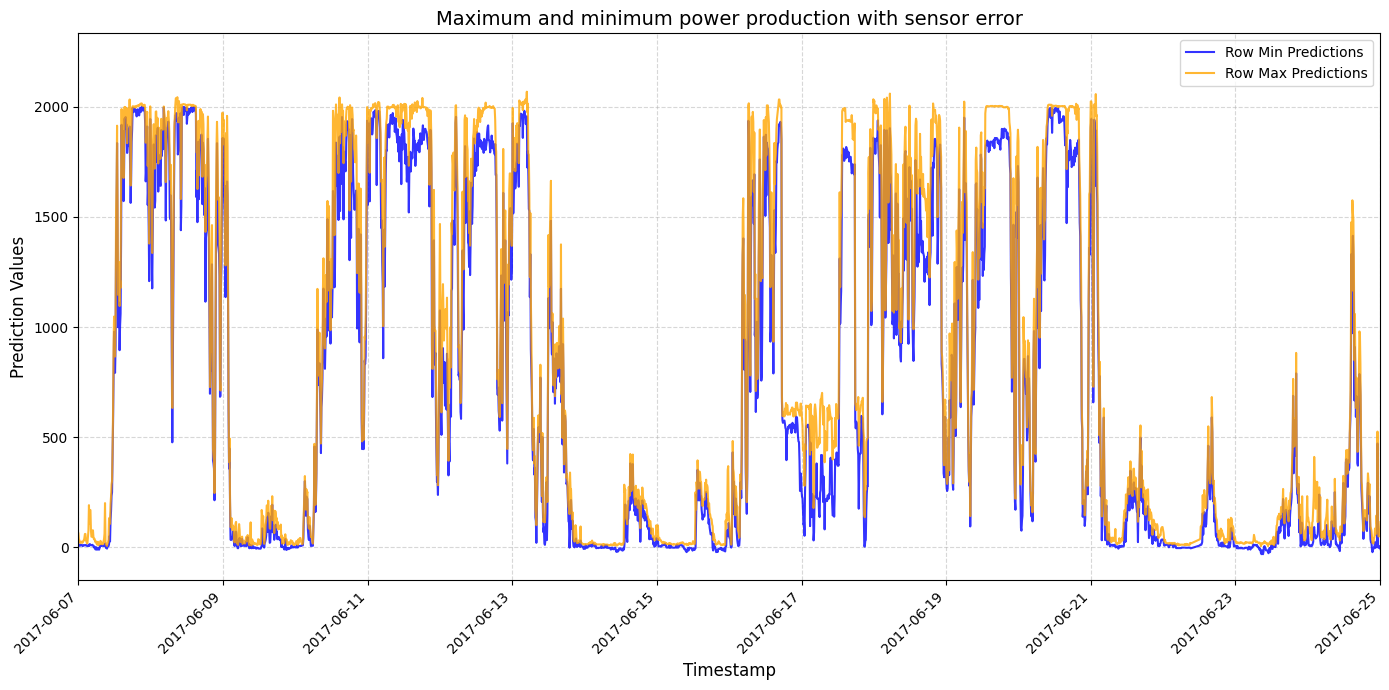

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot min and max predictions over time
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Maximum and minimum power production with sensor error", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Prediction Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


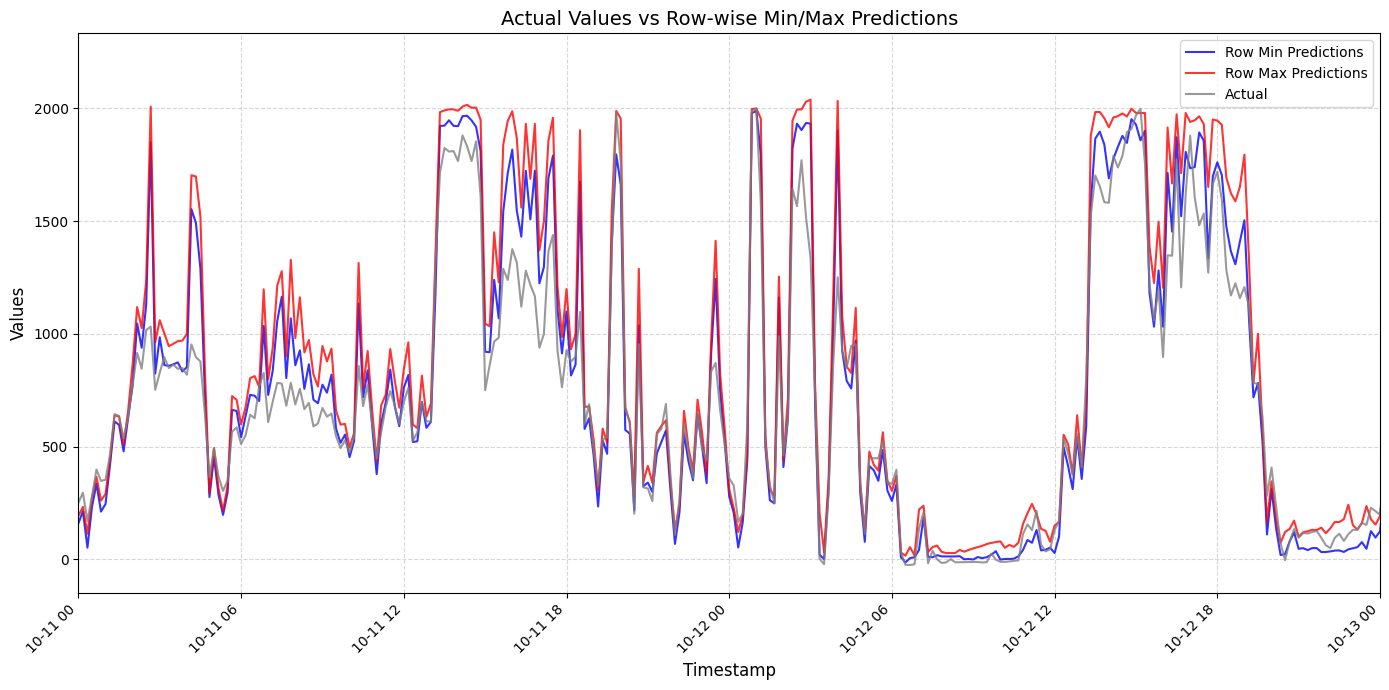

In [ ]:


# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-10-11'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("Actual Values vs Row-wise Min/Max Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


Gaussian filter to smooth the target colum (actual temperature)

In [384]:
from scipy.ndimage import gaussian_filter1d

"""# Apply Gaussian filter
sigma = 1  # Standard deviation for Gaussian kernel (adjust as needed)

merged_df_filtered17_sorted[target_column] = gaussian_filter1d(
    merged_df_filtered17_sorted[target_column], sigma=sigma
)

"""

'# Apply Gaussian filter\nsigma = 1  # Standard deviation for Gaussian kernel (adjust as needed)\n\nmerged_df_filtered17_sorted[target_column] = gaussian_filter1d(\n    merged_df_filtered17_sorted[target_column], sigma=sigma\n)\n\n'

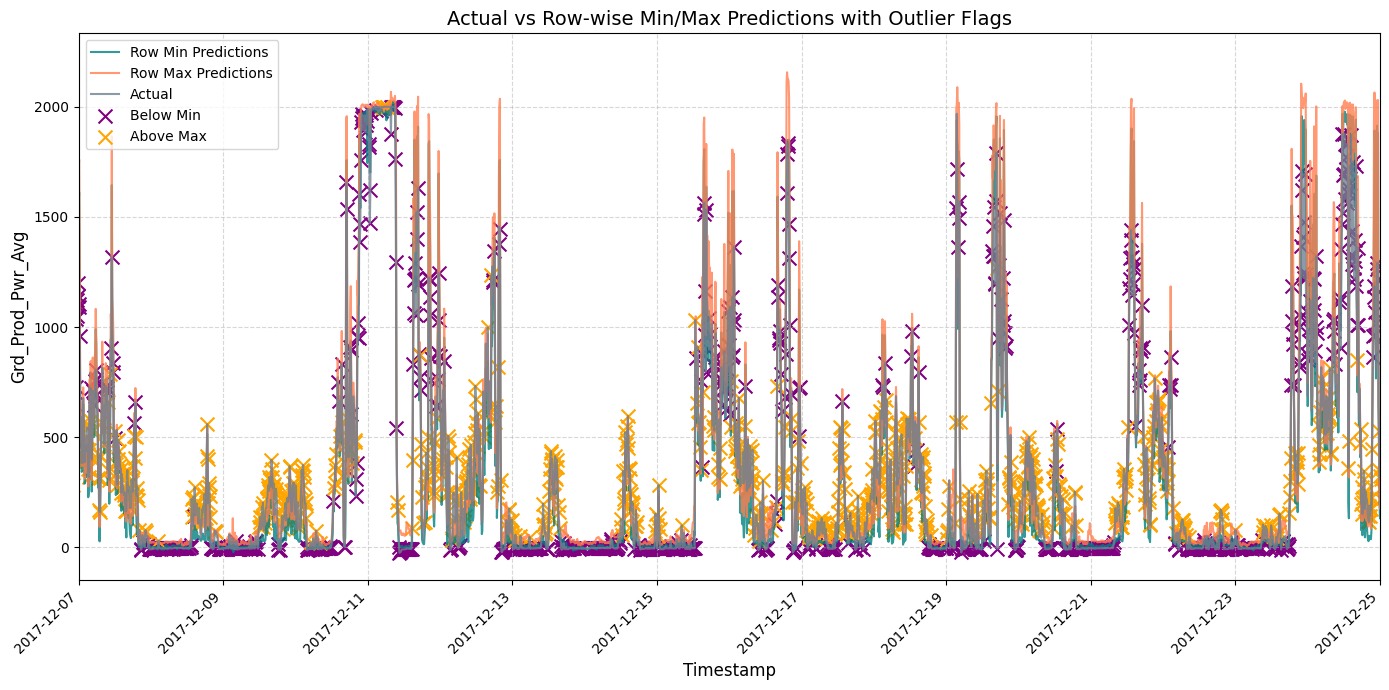

In [385]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)



# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]).astype(int)



# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='teal', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='coral', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='slategrey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label='Below Min'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label='Above Max'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Outlier Flags", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


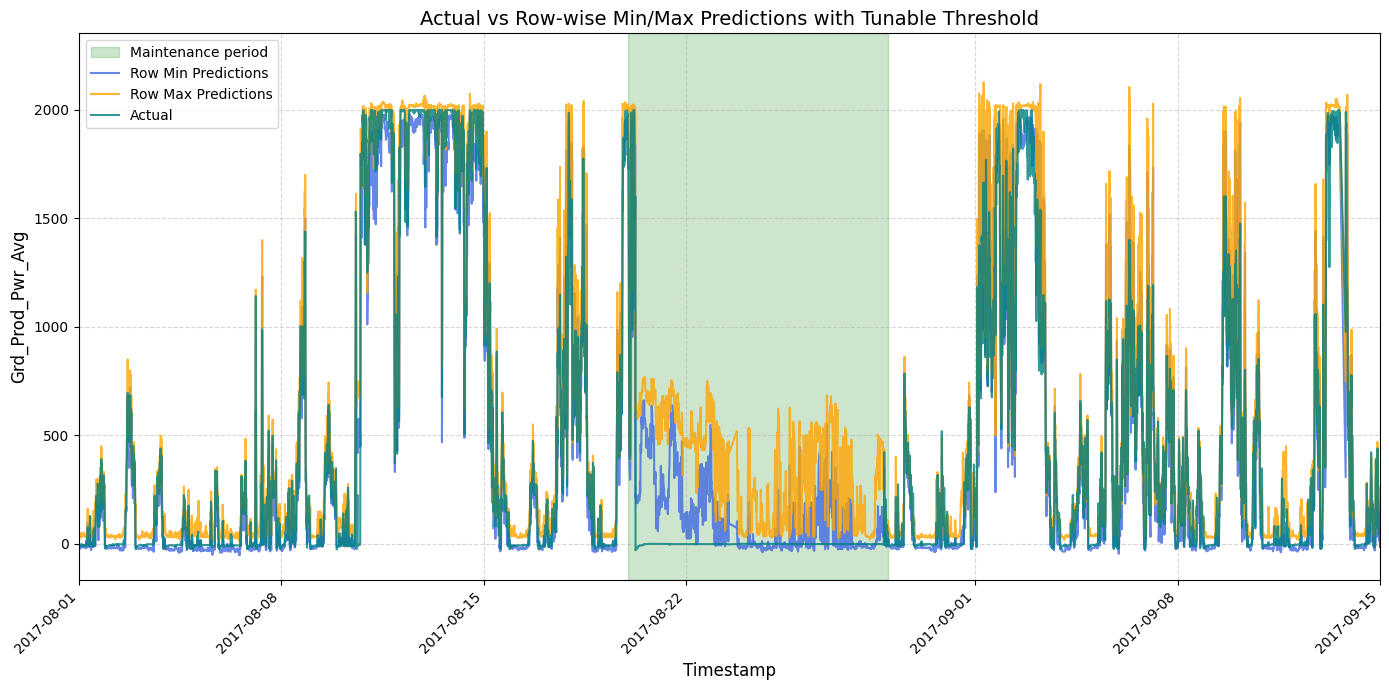

In [386]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

"""# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='coral', marker='x', s=50, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max + {threshold}'
)"""

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2017-09-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


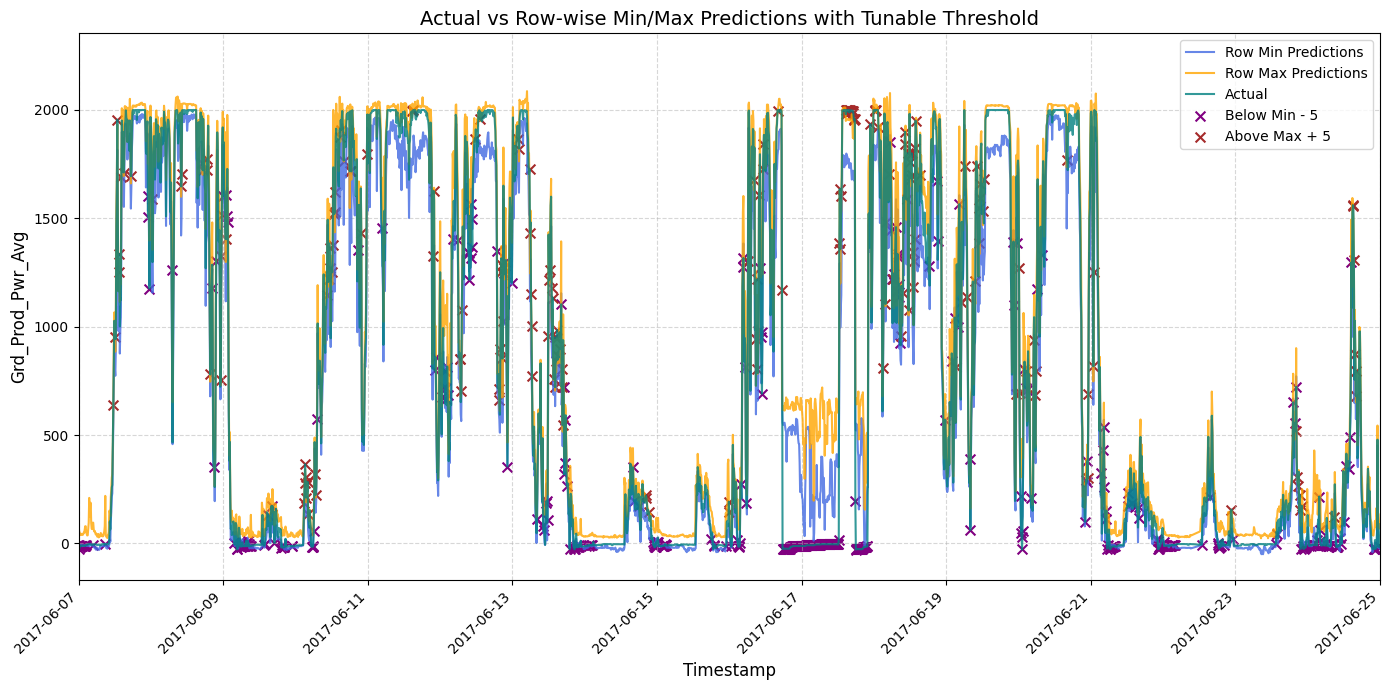

In [387]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)


##### Inserted filtering ######

"""sigma = 2  # Standard deviation for Gaussian kernel (adjust as needed)
merged_df_filtered17_sorted["row_min"] = gaussian_filter1d(
    merged_df_filtered17_sorted["row_min"], sigma=sigma
)
merged_df_filtered17_sorted["row_max"] = gaussian_filter1d(
    merged_df_filtered17_sorted["row_max"], sigma=sigma
)
"""
##### filtering finished ######

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-modelling_error, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+modelling_error, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=50, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max + {threshold}'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [388]:
modelling_error

np.float64(18.5980224609375)

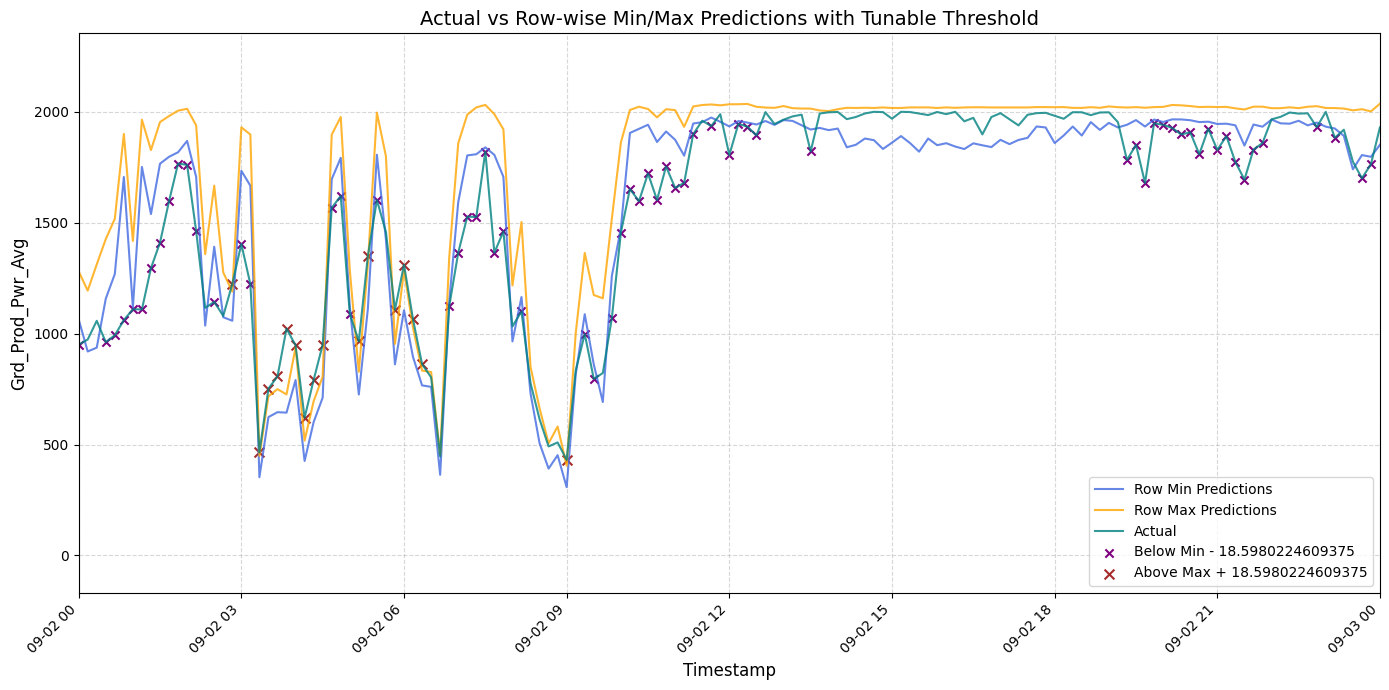

In [389]:
# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for sensor variational error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - (modelling_error))
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + (modelling_error))
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Below Min - {modelling_error}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max + {modelling_error}'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-09-02'), pd.to_datetime('2017-09-3'))


# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


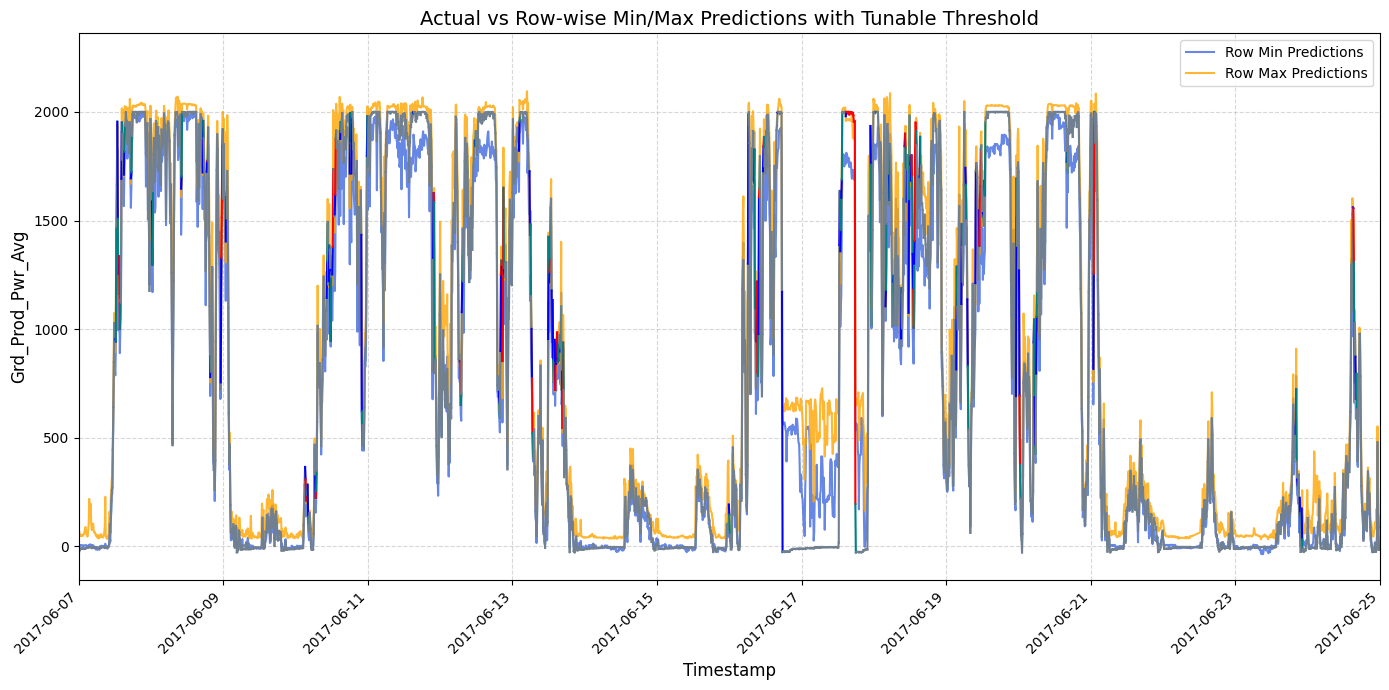

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Define actual values
timestamps = merged_df_filtered17_sorted["Timestamp"]
actual_values = merged_df_filtered17_sorted[target_column]
upper_bound = merged_df_filtered17_sorted["row_max"] + modelling_error
# Start plotting
plt.figure(figsize=(14, 7))

# Plot row-wise min and max thresholds
plt.plot(timestamps, merged_df_filtered17_sorted["row_min"] - modelling_error, color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5)
plt.plot(timestamps, upper_bound, color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5)

# Dynamically change color of the actual line
prev_above = False
for i in range(len(timestamps) - 1):
    current_above = actual_values.iloc[i] > upper_bound.iloc[i]
    
    if i == 0 or current_above != prev_above:
        plt.plot(
            timestamps[i : i + 2], 
            actual_values.iloc[i : i + 2], 
            color='blue' if current_above else 'teal', 
            linewidth=1.5
        )
    else:
        plt.plot(
            timestamps[i : i + 2], 
            actual_values.iloc[i : i + 2], 
            color='red' if current_above else 'slategrey', 
            linewidth=1.5
        )
    
    prev_above = current_above

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [353]:
"""import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
buffer = 3  # Additional buffer above row_max to consider as a high point
check_slope_window = 1  # Number of rows (Z) to check slope before initiating anomalies
consecutive_steps = 1  # Number of positive slope steps to confirm peak anomalies
max_length = 2 # Maximum sequence length for anomalies
lower_limit = 10  # Lower operational limit
upper_limit = 100  # Upper operational limit

# Flags to control slope dependency checks
check_slope = False  # Set to False to deactivate slope checks (checks the initial slope of Z)
check_ongoing_slope = False  # Set to False to deactivate ongoing slope checks (cancels if an ongoing negative slope is detected)
final_slope_check = False  # Set to False to deactivate final slope check throw (checks if there are only negative slopes and throws away the anomaly if it is only negative)
final_overall_slope_check = True  # Set to True to enable final overall slope check (throws away anomaly if the overall slope is negative)
max_consecutive_negative_slopes = 1  # Max consecutive negative slopes before discarding anomaly

# Calculate the difference from row_max
merged_df_filtered17_sorted["difference"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] - (merged_df_filtered17_sorted["row_max"] + buffer)
)

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column for marking anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    if i >= check_slope_window:
        # Check slope in the last Z rows if slope checks are enabled
        if check_slope:
            recent_temps = merged_df_filtered17_sorted.iloc[i - check_slope_window : i]["Gen_Bear_Temp_Avg"].values
            slope = np.polyfit(range(check_slope_window), recent_temps, 1)[0]  # Fit linear slope

            # Proceed only if slope is positive
            if slope <= 0:
                continue  # Skip this row if slope is non-positive
        
        # Start anomaly detection if current difference > 0
        if merged_df_filtered17_sorted.iloc[i]["difference"] > 0:
            temp_list = []
            start_idx = i
            slopes_between_points = []  # List to store slopes between points
            consecutive_negative_slopes = 0  # Counter for consecutive negative slopes

            # Begin sequence recording
            while i < len(merged_df_filtered17_sorted):
                current_temp = merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"]
                temp_list.append(current_temp)

                # Check ongoing slope if enabled
                if len(temp_list) > 1 and check_ongoing_slope:
                    ongoing_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    if ongoing_slope <= 0:
                        break  # Break if slope is not positive

                # Validate sequence with buffer and slope
                if (
                    merged_df_filtered17_sorted.iloc[i]["difference"] <= 0
                    or len(temp_list) > max_length
                ):
                    break

                # Store slope between consecutive points if there are enough points
                if len(temp_list) > 1:
                    slope_between_points = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    slopes_between_points.append(slope_between_points)

                    # Count consecutive negative slopes
                    if slope_between_points <= 0:
                        consecutive_negative_slopes += 1
                    else:
                        consecutive_negative_slopes = 0  # Reset counter if positive slope is found

                i += 1

            # Final anomaly validation with slope check if enabled
            if len(temp_list) >= consecutive_steps:
                avg_temp = np.mean(temp_list)

                # If the final slope check is enabled, check if consecutive negative slopes exceed threshold
                if final_slope_check and consecutive_negative_slopes >= max_consecutive_negative_slopes:
                    continue  # Discard if too many consecutive negative slopes

                # Final overall slope check (if enabled)
                if final_overall_slope_check:
                    overall_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    if overall_slope <= 0:
                        continue  # Discard anomaly if overall slope is negative

                # Validate anomaly with temperature and slope conditions
                if avg_temp > lower_limit and avg_temp < upper_limit:
                    merged_df_filtered17_sorted.loc[
                        merged_df_filtered17_sorted.index[start_idx:i], "anomaly_flag"
                    ] = 1

# Visualization
plt.figure(figsize=(14, 7))

# Scatter anomalies
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="orange",
    label="Anomalies",
    s=50,
)

plt.legend()
plt.title("Anomaly Detection with Tuned Peaks and Slope Checks")
plt.xlabel("Timestamp")
plt.ylabel("Gen_Bear_Temp_Avg")
plt.grid(alpha=0.5)
plt.show()"""

'import matplotlib.pyplot as plt\nimport numpy as np\nimport pandas as pd\n\n# Parameters\nbuffer = 3  # Additional buffer above row_max to consider as a high point\ncheck_slope_window = 1  # Number of rows (Z) to check slope before initiating anomalies\nconsecutive_steps = 1  # Number of positive slope steps to confirm peak anomalies\nmax_length = 2 # Maximum sequence length for anomalies\nlower_limit = 10  # Lower operational limit\nupper_limit = 100  # Upper operational limit\n\n# Flags to control slope dependency checks\ncheck_slope = False  # Set to False to deactivate slope checks (checks the initial slope of Z)\ncheck_ongoing_slope = False  # Set to False to deactivate ongoing slope checks (cancels if an ongoing negative slope is detected)\nfinal_slope_check = False  # Set to False to deactivate final slope check throw (checks if there are only negative slopes and throws away the anomaly if it is only negative)\nfinal_overall_slope_check = True  # Set to True to enable final ove

KeyError: 'anomaly_flag'

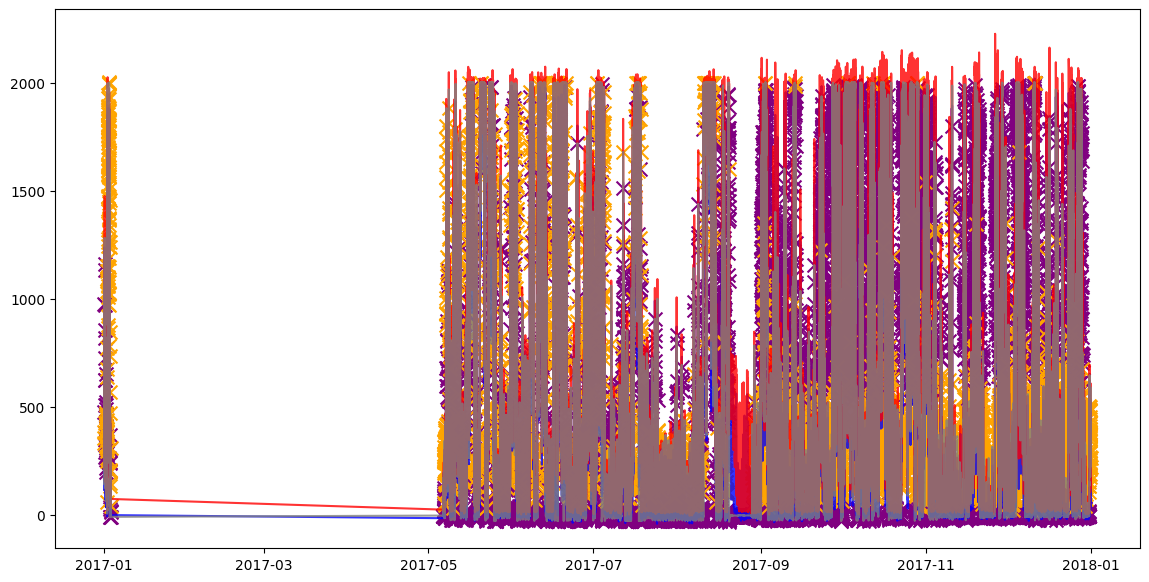

In [354]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 5  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-threshold, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+threshold, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies[target_column],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(merged_df_filtered17_sorted["Timestamp"].min(), merged_df_filtered17_sorted["Timestamp"].max())

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


KeyError: 'anomaly_flag'

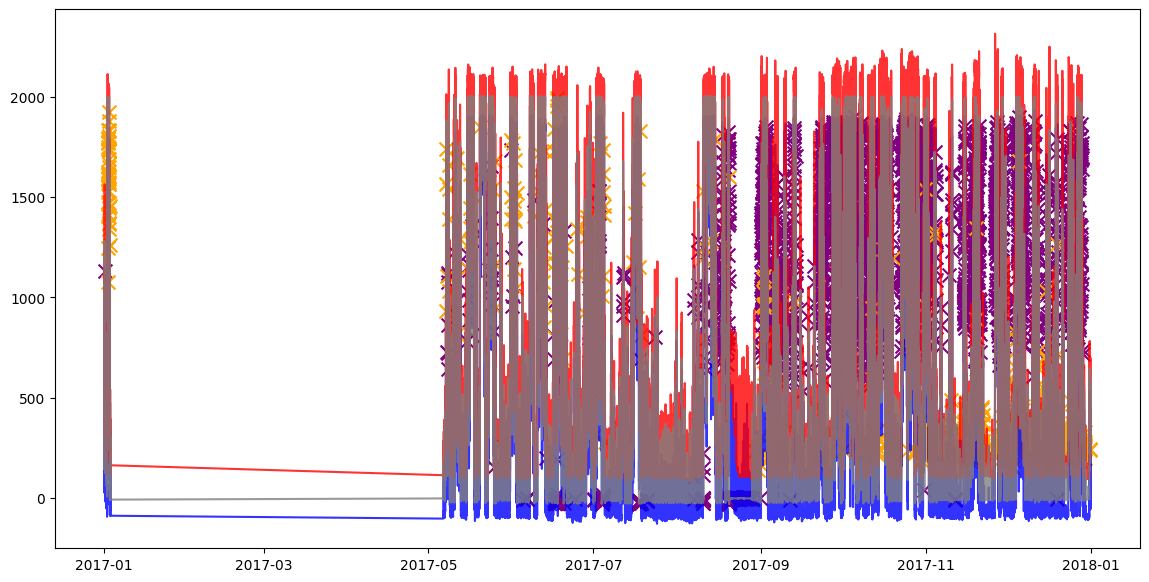

In [355]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 5  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-modelling_error, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+modelling_error, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {modelling_error}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {modelling_error}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies[target_column],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjusted for the timeframe from the plot you provided)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


KeyError: 'anomaly_flag'

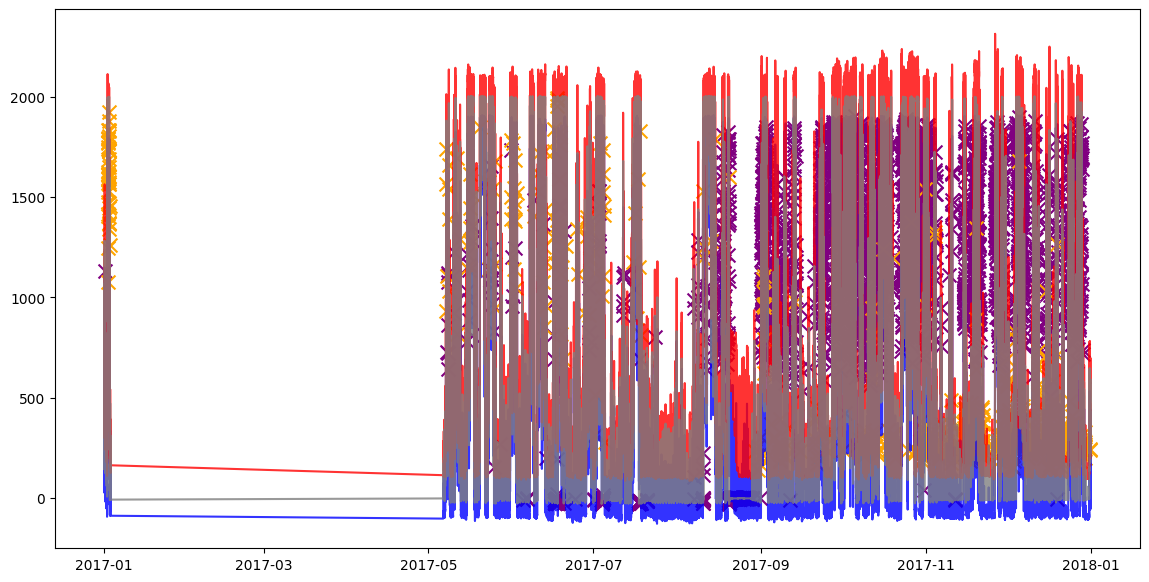

In [356]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
 # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-modelling_error, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+modelling_error, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {modelling_error}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {modelling_error}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies[target_column],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjusted for the timeframe from the plot you provided)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))


# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Power", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd

threshold = 5

# Calculate the difference between `row_max + threshold` and the actual temperature
merged_df_filtered17_sorted['diff_max_actual'] = (
    merged_df_filtered17_sorted[target_column] - (merged_df_filtered17_sorted['row_max'] + threshold)
)

# Remove rows with NaN values
merged_df_filtered17_sorted = merged_df_filtered17_sorted.dropna(subset=['diff_max_actual'])

# === Isolation Forest Model ===
# Train the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.00001, random_state=42)
merged_df_filtered17_sorted['anomaly_isolation'] = isolation_forest.fit_predict(
    merged_df_filtered17_sorted[['diff_max_actual']]
)

# Convert Isolation Forest predictions to anomaly flags (1 for anomalies, 0 otherwise)
merged_df_filtered17_sorted['anomaly_isolation'] = (
    merged_df_filtered17_sorted['anomaly_isolation'] == -1
).astype(int)

# === Z-Score Model ===
# Calculate Z-scores for `diff_max_actual`
merged_df_filtered17_sorted['z_score'] = zscore(merged_df_filtered17_sorted['diff_max_actual'])

# Define an anomaly threshold for Z-score (e.g., absolute value > 3)
z_score_threshold = 5
merged_df_filtered17_sorted['anomaly_z_score'] = (
    merged_df_filtered17_sorted['z_score'].abs() > z_score_threshold
).astype(int)

# === Visualization ===
plt.figure(figsize=(14, 7))

# Scatter plot for Isolation Forest anomalies
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    c=merged_df_filtered17_sorted["anomaly_isolation"],
    cmap="coolwarm",
    label="Isolation Forest Anomalies",
    s=50
)

# Scatter plot for Z-score anomalies
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["anomaly_z_score"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["anomaly_z_score"] == 1],
    color='green',
    marker='x',
    s=100,
    label="Z-Score Anomalies"
)

# Add reference lines
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + threshold, 
    color='red', linestyle="--", label="Row Max + Threshold"
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column], 
    color='grey', label="Actual Temperatures"
)

# Configure plot
plt.title("Anomaly Detection: Isolation Forest and Z-Score", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (\u00b0C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Apply x-axis limits
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-08-25'))

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === Visualization ===
plt.figure(figsize=(14, 7))

# Plot diff_max_actual with time
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["diff_max_actual"], 
    color='teal', label="diff_max_actual"
)

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Anomaly Threshold (0)")

# Configure plot
plt.title("Diff Max Actual Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Diff Max Actual", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Apply x-axis limits
plt.xlim(pd.to_datetime('2017-05-07'), pd.to_datetime('2017-12-25'))

# Show plot
plt.show()


In [ ]:
# Plot the feature with Timestamp on the x-axis and apply x-axis limits for better visibility
plt.figure(figsize=(14, 7))
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['diff_max_actual'], label='diff_max_actual', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold (0)')
plt.title('Feature Plot with Anomalies Over Time')
plt.xlabel('Timestamp')
plt.ylabel('diff_max_actual')
plt.legend()
plt.grid()

# Limiting the x-axis to show a specific portion of the data for clarity
plt.xlim(merged_df_filtered17_sorted['Timestamp'].iloc[0], 
         merged_df_filtered17_sorted['Timestamp'].iloc[100])  # Example: first 100 points
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Filter the data by date range
date_filtered_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= pd.to_datetime("2017-06-07").tz_localize("UTC")) &
    (merged_df_filtered17_sorted["Timestamp"] <= pd.to_datetime("2017-12-25").tz_localize("UTC"))
]
date_filtered_data.dropna(subset=["Gen_Bear_Temp_Avg", target_column, "Timestamp"])
# Use the smaller dataset for pairwise calculations
temperature_data = date_filtered_data["Gen_Bear_Temp_Avg"].values
actual = date_filtered_data["Gen_Bear_Temp_Avg"].values
predicted = date_filtered_data[target_column].values
timestamps = date_filtered_data["Timestamp"].values

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Combine actual and predicted into a single array for clustering
data_for_clustering = np.column_stack((predicted, actual))


# Remove rows with NaN values
data_for_clustering = data_for_clustering[~np.isnan(data_for_clustering).any(axis=1)]
# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust clusters if needed
date_filtered_data["Cluster"] = kmeans.fit_predict(data_for_clustering)

# Visualize clusters
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(kmeans.labels_):
    cluster_points = date_filtered_data[date_filtered_data["Cluster"] == cluster_id]
    plt.scatter(
        cluster_points[target_column],  # X: Predicted
        cluster_points["Gen_Bear_Temp_Avg"],  # Y: Actual
        label=f"Cluster {cluster_id}"
    )

plt.plot(predicted, predicted, color="red", linestyle="--", label="Prediction Reference Line")
plt.title("K-Means Clustering: Actual vs Predicted")
plt.xlabel("Predicted Temperature")
plt.ylabel("Actual Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Combine predicted and actual values into a DataFrame for cleaning
data_for_clustering = pd.DataFrame({
    "predicted": predicted,
    "actual": actual
})

# Drop rows with NaN values
data_for_clustering.dropna(inplace=True)

# Convert back to NumPy array
data_for_clustering = data_for_clustering.values

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(data_for_clustering)

# Assign cluster labels back to the original DataFrame
date_filtered_data = date_filtered_data.iloc[:len(data_for_clustering)].copy()  # Adjust length to match cleaned data
date_filtered_data["DBSCAN_Cluster"] = dbscan.labels_

# Visualize DBSCAN clusters
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(dbscan.labels_):
    cluster_points = date_filtered_data[date_filtered_data["DBSCAN_Cluster"] == cluster_id]
    plt.scatter(
        cluster_points[target_column],  # X: Predicted
        cluster_points["Gen_Bear_Temp_Avg"],  # Y: Actual
        label=f"Cluster {cluster_id}" if cluster_id != -1 else "Outliers"
    )

plt.plot(predicted, predicted, color="red", linestyle="--", label="Prediction Reference Line")
plt.title("DBSCAN Clustering: Actual vs Predicted")
plt.xlabel("Predicted Temperature")
plt.ylabel("Actual Temperature")
plt.legend()
plt.grid()
plt.show()



In [ ]:
date_filtered_data['Rolling_Mean'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).mean()
date_filtered_data['Rolling_Std'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).std()
date_filtered_data['Anomaly'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - date_filtered_data['Rolling_Mean']) > 2 * date_filtered_data['Rolling_Std']


In [ ]:
from scipy.stats import zscore
date_filtered_data['Z_Score'] = zscore(date_filtered_data['Gen_Bear_Temp_Avg'])
date_filtered_data['Anomaly_Z_Score'] = abs(date_filtered_data['Z_Score']) > 2


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Z_Score']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Z_Score']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Z-Score")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.02)  # Adjust contamination rate as needed
date_filtered_data['Anomaly_IF'] = iso_forest.fit_predict(data_for_clustering)

# Convert -1 (anomalous) and 1 (normal) to boolean for easy filtering
date_filtered_data['Anomaly_IF'] = date_filtered_data['Anomaly_IF'] == -1


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_IF']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_IF']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Isolation Forest")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


Additional isolation forrest

In [ ]:
"""# Check for duplicate timestamps
if 'Turbine_ID' in date_filtered_data.columns:
    date_filtered_data.drop(columns=['Turbine_ID'], inplace=True)

# Drop duplicate timestamps, keeping the first occurrence
date_filtered_data = date_filtered_data[~date_filtered_data.index.duplicated(keep='first')]

# Alternatively, aggregate duplicate timestamps by averaging
date_filtered_data = date_filtered_data.groupby(date_filtered_data.index).mean()

"""



In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Reset index to ensure 'Timestamp' is available as a column
date_filtered_data.reset_index(inplace=True)

# Remove timezone information from the Timestamp column if any
date_filtered_data['Timestamp'] = date_filtered_data['Timestamp'].dt.tz_localize(None)

# Prepare the data for Prophet (ensure 'Timestamp' is now a column)
df_prophet = date_filtered_data[['Timestamp', 'Gen_Bear_Temp_Avg']].rename(columns={'Timestamp': 'ds', 'Gen_Bear_Temp_Avg': 'y'})

# Ensure the datetime column 'ds' has a proper frequency (set frequency to daily 'D')
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future predictions (here we are just forecasting for the historical data)
future = model.make_future_dataframe(df_prophet, freq='D')
forecast = model.predict(future)

# Detect anomalies where actual values deviate significantly from the forecast
date_filtered_data['Anomaly_Prophet'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - forecast['yhat']) > 2 * (forecast['yhat_upper'] - forecast['yhat_lower'])

# Plot the actual data and forecast with anomalies
plt.figure(figsize=(14, 7))

# Plot the actual temperature
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], color='grey', alpha=0.8, label='Actual', linewidth=1.5)

# Plot the forecasted temperature (mean, upper, and lower bounds)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='blue', linewidth=1.5)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight anomalies (where actual temperature deviates significantly from forecast)
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies", s=80)

# Customize the plot
plt.title("Actual vs Forecasted Temperature with Anomalies Detected", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import STL

# Ensure the Timestamp column is in datetime format
date_filtered_data['Timestamp'] = pd.to_datetime(date_filtered_data['Timestamp'])

# Set the frequency of the time series (daily in this case)
date_filtered_data.set_index('Timestamp', inplace=True)
date_filtered_data = date_filtered_data.asfreq('D')  # Set frequency to daily (change if needed)

# Perform STL decomposition
stl = STL(date_filtered_data['Gen_Bear_Temp_Avg'], seasonal=13)
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

# Use the residuals to detect anomalies
residuals = result.resid
date_filtered_data['Anomaly_STL'] = abs(residuals) > 2 * residuals.std()

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data.index, date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data.index[date_filtered_data['Anomaly_STL']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_STL']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using STL Decomposition")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Reset index to ensure 'Timestamp' is available as a column
date_filtered_data.reset_index(inplace=True)

# Remove timezone information from the Timestamp column if any
date_filtered_data['Timestamp'] = date_filtered_data['Timestamp'].dt.tz_localize(None)

# Prepare the data for Prophet (ensure 'Timestamp' is now a column)
df_prophet = date_filtered_data[['Timestamp', 'Gen_Bear_Temp_Avg']].rename(columns={'Timestamp': 'ds', 'Gen_Bear_Temp_Avg': 'y'})

# Ensure the datetime column 'ds' has a proper frequency (set frequency to daily 'D')
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future predictions (here we are just forecasting for the historical data)
future = model.make_future_dataframe(df_prophet, freq='D')
forecast = model.predict(future)

# Detect anomalies where actual values deviate significantly from the forecast
date_filtered_data['Anomaly_Prophet'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - forecast['yhat']) > 2 * (forecast['yhat_upper'] - forecast['yhat_lower'])

# Plot the actual data and forecast with anomalies
plt.figure(figsize=(14, 7))

# Plot the actual temperature
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], color='grey', alpha=0.8, label='Actual', linewidth=1.5)

# Plot the forecasted temperature (mean, upper, and lower bounds)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='blue', linewidth=1.5)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight anomalies (where actual temperature deviates significantly from forecast)
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies", s=80)

# Customize the plot
plt.title("Actual vs Forecasted Temperature with Anomalies Detected", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Prophet Model")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Drop rows with missing values in 'Gen_Bear_Temp_Avg'
merged_df_filtered17_sorted = merged_df_filtered17_sorted.dropna(subset=['Gen_Bear_Temp_Avg'])

# Now proceed with LOF model
from sklearn.neighbors import LocalOutlierFactor

# Define the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model and predict anomalies
X = merged_df_filtered17_sorted[['Gen_Bear_Temp_Avg']]  # Actual temperature data (or combine predicted and actual)
merged_df_filtered17_sorted['anomaly_lof'] = lof.fit_predict(X)
merged_df_filtered17_sorted['anomaly_lof'] = merged_df_filtered17_sorted['anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by LOF
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_lof'] == 1]
plt.scatter(anomalies['Timestamp'], anomalies['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (LOF)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Local Outlier Factor (LOF)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Compute Z-scores for Gen_Bear_Temp_Avg
merged_df_filtered17_sorted['z_score'] = (merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'] - merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'].mean()) / merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'].std()

# Define a threshold for anomaly detection
z_threshold = 2.5  # Example threshold: 3 standard deviations

# Flag anomalies where Z-score is above or below the threshold
merged_df_filtered17_sorted['anomaly_zscore'] = (np.abs(merged_df_filtered17_sorted['z_score']) > z_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Z-score
anomalies_zscore = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_zscore'] == 1]
plt.scatter(anomalies_zscore['Timestamp'], anomalies_zscore['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Z-score)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Z-Score Method", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-06-07'
end_date = '2017-10-25'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-12-07'
end_date = '2017-12-15'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.svm import OneClassSVM

# Initialize One-Class SVM
oc_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma="auto")

# Fit the model and predict anomalies
X = merged_df_filtered17_sorted[['Gen_Bear_Temp_Avg']]  # You can use a combination of actual and predicted values
merged_df_filtered17_sorted['anomaly_svm'] = oc_svm.fit_predict(X)
merged_df_filtered17_sorted['anomaly_svm'] = merged_df_filtered17_sorted['anomaly_svm'].apply(lambda x: 1 if x == -1 else 0)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by One-Class SVM
anomalies_svm = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_svm'] == 1]
plt.scatter(anomalies_svm['Timestamp'], anomalies_svm['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (SVM)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by One-Class SVM", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
